In [175]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings("ignore")
torch.set_printoptions(precision=20, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=None)
layer_size = 9

In [176]:
x_train = torch.tensor([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0], dtype=torch.float, requires_grad=True)
x_train=x_train.reshape(-1,1)
y_train_DrParand= torch.tensor([[0.000000000000,0.165571725847,0.650024370165,1.396808231342,2.305746419194,3.283273666139,4.279620923737,5.279238812489,6.279213433045]], dtype=torch.float,requires_grad=True)

y_train=y_train_DrParand
y_train=y_train.reshape(-1,1)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=3, shuffle=True,drop_last=True)

In [177]:
class CustomActivationLayer(nn.Module):
    def __init__(self, input_size, output_size,L):
        super(CustomActivationLayer, self).__init__()
        self.L=L

        # Ensure the output size matches the number of custom functions
        assert output_size == 9, "This example requires exactly 3 output nodes."

    def forward(self, x):
        # Get the linear output
        linear_out = x
        L=self.L
        activated_out = torch.stack([
            linear_out[:,0]*0+1.0,
            (linear_out[:,1]-L)/(linear_out[:,1]+L),
            1.5*((linear_out[:,2]-L)/(linear_out[:,2]+L))**2-1.5,
            2.5*((linear_out[:,3]-L)/(linear_out[:,3]+L))**3-1.5*((linear_out[:,3]-L)/(linear_out[:,3]+L)),
            4.375*((linear_out[:,4]-L)/(linear_out[:,4]+L))**4-3.75*((linear_out[:,4]-L)/(linear_out[:,4]+L))**2+0.375,
            7.875*((linear_out[:,5]-L)/(linear_out[:,5]+L))**5-8.75*((linear_out[:,5]-L)/(linear_out[:,5]+L))**3+1.875**((linear_out[:,5]-L)/(linear_out[:,5]+L)),
            14.4375*((linear_out[:,6]-L)/(linear_out[:,6]+L))**6-19.6875*((linear_out[:,6]-L)/(linear_out[:,6]+L))**4 +6.5625*((linear_out[:,6]-L)/(linear_out[:,6]+L))**2 - 0.3125,
            26.8125*((linear_out[:,7]-L)/(linear_out[:,7]+L))**7-43.3125*((linear_out[:,7]-L)/(linear_out[:,7]+L))**5 +19.6875*((linear_out[:,7]-L)/(linear_out[:,7]+L))**3 -2.1875*((linear_out[:,7]-L)/(linear_out[:,7]+L)),
            50.2734375*((linear_out[:,8]-L)/(linear_out[:,8]+L))**8-93.84375*((linear_out[:,8]-L)/(linear_out[:,8]+L))**6+54.140625*((linear_out[:,8]-L)/(linear_out[:,8]+L))**4-9.84375*((linear_out[:,8]-L)/(linear_out[:,8]+L))**2 +0.2734375,
            #94.9609375*((linear_out[:,9]-L)/(linear_out[:,9]+L))**9-201.09375*((linear_out[:,9]-L)/(linear_out[:,9]+L))**7+140.765625*((linear_out[:,9]-L)/(linear_out[:,9]+L))**5-36.09375*((linear_out[:,9]-L)/(linear_out[:,9]+L))**3+2.4609375*((linear_out[:,9]-L)/(linear_out[:,9]+L)),
            #180.42578125*((linear_out[:,10]-L)/(linear_out[:,10]+L))**10-427.32421875*((linear_out[:,10]-L)/(linear_out[:,10]+L))**8+351.9140625*((linear_out[:,10]-L)/(linear_out[:,10]+L))**6-117.3046875*((linear_out[:,10]-L)/(linear_out[:,10]+L))**4+13.53515625*((linear_out[:,10]-L)/(linear_out[:,10]+L))**2-0.2460937500000
        ], dim=1)
        return activated_out


In [178]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1, layer_size, bias=False)
        self.a1 = nn.Tanh()
        self.l2 = nn.Linear(layer_size, layer_size, bias=False)
        self.a2 = nn.Tanh()
        self.a3 = CustomActivationLayer(layer_size, layer_size, 4.0)
        self.l3 = nn.Linear(layer_size, 1, bias=False)

    def forward(self, x):
        x=self.l1(x)
        x=self.a1(x)
        x=self.l2(x)
        x=self.a2(x)
        x=self.a3(x)
        x=self.l3(x)
        return x+1.0
model=MyModule()



Mean Absolute Error 0.17957928776741028


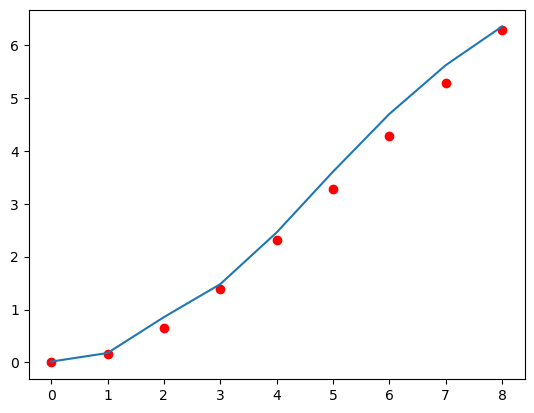

In [180]:
y_pred = model(x_train)
MAE=torch.abs(y_train-y_pred).mean()
print('Mean Absolute Error',MAE.item())
y_pred = y_pred.detach().numpy()
plt.plot(x_train.detach().numpy(), y_pred)
plt.scatter(x_train.detach().numpy(),y_train.detach().numpy(),c='red')
plt.show()


In [181]:
x=torch.linspace(0,10,100,requires_grad=True)
x=x.reshape(-1,1)

In [182]:
model=MyModule()


In [183]:
def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True,allow_unused=True
    )[0]


In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [190]:
losses=[]
n_epochs=20000

for i in range(n_epochs):
    y=model(x)
    y_p = dy_dx(y, x)
    y_pp = dy_dx(y_p, x)
    y_ppp = dy_dx(y_pp, x)

    residential = y_ppp+0.5*y*y_pp
    initial1 = y[0] - 0
    initial2 = y_p[0] - 0
    initial3 = y_p[-1]-.99

    loss = 10*initial3**2+1000*(residential**2).mean() + initial1**2 + initial2**2
    if loss.item() < 0.00099:
        break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

    if i % 1000 == 0:
        print('Epoch=',i,' ,Loss=',loss.detach().numpy()[0])



Epoch= 0  ,Loss= 0.0023487033


In [191]:
print(y_p[-1])


tensor([0.99044489860534667969], grad_fn=<SelectBackward0>)


In [192]:
def eval_residual(x):
    y=model(x)
    y_p = dy_dx(y, x)
    y_pp = dy_dx(y_p, x)
    y_ppp = dy_dx(y_pp, x)

    print('y_pp(0)=',y_pp[0].item())
    # modify the equation to match the one you sent
    residential = y_ppp+0.5*y*y_pp
    initial1 = y[0] - 1
    initial2 = y_p[0] - 0
    initial3 = y_p[-1]-.990
    return (residential**2).mean() + initial1 + initial2+ initial3
res=eval_residual(x)
y_pred=model(x)

print('Mean Residual=',res.item())


y_pp(0)= 0.3317602872848511
Mean Residual= -0.9920282363891602


Mean Absolute Error Between Dr Parand results and the presented model: 0.015845321118831635


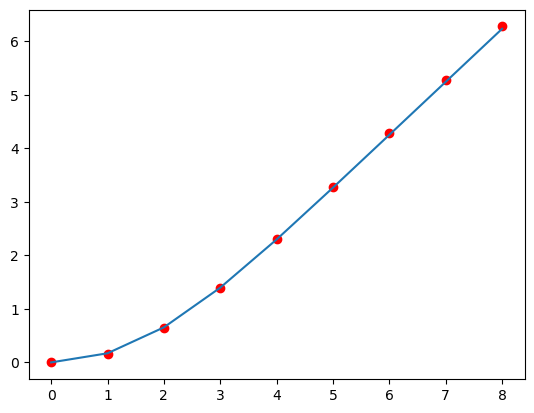

In [193]:
x= torch.tensor([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0], dtype=torch.float, requires_grad=True)
x=x.reshape(-1,1)
y_pred = model(x)
MAE=torch.abs(y_train-y_pred).mean()
print('Mean Absolute Error Between Dr Parand results and the presented model:',MAE.item())
y_pred = y_pred.detach().numpy()
plt.plot(x_train.detach().numpy(), y_pred)
plt.scatter(x_train.detach().numpy(),y_train.detach().numpy(),c='red')
plt.show()


In [194]:
def calculate_y_and_ypp(model, x_values, x_for_ypp):
    """
    Calculate y values for specific x_values and y'' at a single point x_for_ypp.

    Args:
    - model: The trained PyTorch model.
    - x_values: A tensor of x values where y needs to be calculated.
    - x_for_ypp: A single float value where y'' needs to be calculated.

    Returns:
    - y_values: A tensor of y values at x_values.
    - ypp_at_point: The value of y'' at x_for_ypp.
    """
    # Ensure x_values and x_for_ypp are tensors
    x_values = x_values.reshape(-1, 1)  # Reshape for model input
    x_for_ypp = torch.tensor([x_for_ypp], dtype=torch.float, requires_grad=True).reshape(-1, 1)

    # Calculate y values for x_values
    y_values = model(x_values).detach().numpy()  # Detach for no gradient computation

    # Calculate y'' at x_for_ypp
    y_at_point = model(x_for_ypp)
    y_prime_at_point = torch.autograd.grad(
        y_at_point, x_for_ypp, grad_outputs=torch.ones_like(y_at_point), create_graph=True
    )[0]
    y_double_prime_at_point = torch.autograd.grad(
        y_prime_at_point, x_for_ypp, grad_outputs=torch.ones_like(y_prime_at_point), create_graph=True
    )[0]

    return y_values, y_double_prime_at_point.item()

# Define x values where you want y to be calculated
x_values = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype=torch.float)

# Define the point where you want y'' to be calculated
x_for_ypp = 0.0

# Call the function
y_values, ypp_at_0 = calculate_y_and_ypp(model, x_values, x_for_ypp)

# Print results
print("y values at x =", x_values.tolist(), ":", y_values)
print("y'' at x = 0:", ypp_at_0)


def calculate_y_yprime_ypp(model, x_values):
    """
    Calculate y, y', and y'' for each x in x_values.

    Args:
    - model: The trained PyTorch model.
    - x_values: A tensor of x values where y, y', y'' need to be calculated.

    Returns:
    - y_values: A list of y values at x_values.
    - y_prime_values: A list of y' values at x_values.
    - y_double_prime_values: A list of y'' values at x_values.
    """
    y_values = []
    y_prime_values = []
    y_double_prime_values = []
    
    for x in x_values:
        # Ensure x requires gradient for derivative computation
        x_tensor = torch.tensor([x], dtype=torch.float, requires_grad=True).reshape(-1, 1)
        
        # Forward pass to compute y
        y = model(x_tensor)
        y_values.append(y.detach().item())
        
        # Compute first derivative y'
        y_prime = torch.autograd.grad(
            y, x_tensor, grad_outputs=torch.ones_like(y), create_graph=True
        )[0]
        y_prime_values.append(y_prime.detach().item())
        
        # Compute second derivative y''
        y_double_prime = torch.autograd.grad(
            y_prime, x_tensor, grad_outputs=torch.ones_like(y_prime), create_graph=True
        )[0]
        y_double_prime_values.append(y_double_prime.detach().item())
    
    return y_values, y_prime_values, y_double_prime_values

# Example usage:

# Assume 'model' is your pre-trained PyTorch model
# Define x values where you want y, y', and y'' to be calculated
x_values = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype=torch.float)

# Call the function
y_values, y_prime_values, y_double_prime_values = calculate_y_yprime_ypp(model, x_values)

# Print results
print("x values:", x_values.tolist())
print("y values:", y_values)
print("y' values:", y_prime_values)
print("y'' values:", y_double_prime_values)


y values at x = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] : [[1.6732216e-03]
 [1.7191571e-01]
 [6.5599048e-01]
 [1.3981435e+00]
 [2.2989092e+00]
 [3.2671754e+00]
 [4.2543893e+00]
 [5.2444992e+00]
 [6.2348309e+00]
 [7.2251997e+00]]
y'' at x = 0: 0.33176034688949585
x values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
y values: [0.0016732215881347656, 0.17191576957702637, 0.6559908390045166, 1.3981435298919678, 2.2989089488983154, 3.2671756744384766, 4.254384994506836, 5.244499206542969, 6.2348313331604, 7.2251996994018555]
y' values: [0.00585271418094635, 0.3321404457092285, 0.6270735263824463, 0.8394298553466797, 0.946324348449707, 0.9824029803276062, 0.9896964430809021, 0.9902478456497192, 0.9904447197914124, 0.9900507926940918]
y'' values: [0.33176034688949585, 0.3169591426849365, 0.2628591060638428, 0.1574517786502838, 0.06335017830133438, 0.0162107665091753, 0.0019010539399459958, 0.0001020230702124536, 0.000174159329617396, -0.0012916442938148975]
